In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Data collection and preparation

After taking a closer look to the dataset and its meaning, we have decided to use the variable `koi_disposition` as our target variable, which is the data observed by humans. We can see that is a categorical variable containing three classes; False Positive, Confirmed, and Candidate. In order to simplify this analysis, we are going to remove the False Positive cases while trying to predict the Confirmed and Candidate cases, transforming our analysis into a binary classification.

We have removed the variables `kepid` and `kepler_name` since they only serve to identify the points and add no information.\
We also removed `koi_score` since this is the conffidence on the machines prediction and this should not be used as predictive variable.\
We also removed `koi_teq_err1` and `koi_teq_err2` since they only contained missing values.\
Finaly we used `kepoi_name` as the index to identify the rows, as it shows the scientific name of the Kepler object of interest.

In [115]:
data = pd.read_csv('exoplanets.csv')

In [116]:
data.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [117]:
# Drop unnecessary variables
exclude_variables = ["kepid","kepler_name","koi_pdisposition","koi_score","koi_teq_err1","koi_teq_err2"]
df = data.drop(columns=exclude_variables).set_index("kepoi_name")

In [118]:
df.where(df["koi_disposition"] != "FALSE POSITIVE").dropna(axis=0,how="all")

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
kepoi_name,,,,,,,,,,,,,,,,,,,,,
K00752.01,CONFIRMED,0.0,0.0,0.0,0.0,9.488036,0.000028,-0.000028,170.538750,0.002160,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
K00752.02,CONFIRMED,0.0,0.0,0.0,0.0,54.418383,0.000248,-0.000248,162.513840,0.003520,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
K00753.01,CANDIDATE,0.0,0.0,0.0,0.0,19.899140,0.000015,-0.000015,175.850252,0.000581,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
K00755.01,CONFIRMED,0.0,0.0,0.0,0.0,2.525592,0.000004,-0.000004,171.595550,0.001130,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
K00756.01,CONFIRMED,0.0,0.0,0.0,0.0,11.094321,0.000020,-0.000020,171.201160,0.001410,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K07978.01,CANDIDATE,0.0,0.0,0.0,0.0,7.268182,0.000164,-0.000164,135.934800,0.023500,...,-242.0,3.890,0.405,-0.135,2.219,0.536,-0.996,285.30768,46.829803,13.729
K07982.01,CANDIDATE,0.0,0.0,0.0,0.0,376.379890,0.046800,-0.046800,486.602200,0.071100,...,-225.0,4.488,0.054,-0.216,0.955,0.291,-0.097,291.60455,46.973289,15.632
K08193.01,CANDIDATE,0.0,0.0,0.0,0.0,367.947848,0.004790,-0.004790,416.209980,0.009720,...,-166.0,4.561,0.030,-0.170,0.855,0.207,-0.069,297.73398,46.961529,15.719


In [119]:
# Set up target variable
# Use koi_disposition only when it is not a FALSE POSITIVE
df = df.where(df["koi_disposition"] != "FALSE POSITIVE").dropna(axis=0,how="all")
df["koi_disposition"] = df["koi_disposition"].astype("category")
print(df["koi_disposition"].value_counts())


koi_disposition
CANDIDATE    2367
CONFIRMED    2357
Name: count, dtype: int64


## Data exploration

In [120]:
data_stats = {}
nrow=len(df)
for col in df:
    var = df[col]
    data_stats[col] = {}
    data_stats[col]["%miss"] = (var.isnull().sum()/nrow)*100
    data_stats[col]["#unique"] = len(var.drop_duplicates())
    data_stats[col]["type"] = var.dtype.kind
    if data_stats[col]["type"] != "O":
        # Not categorical
        if data_stats[col]["#unique"] > 2:
            # Not Binary
            data_stats[col]["min"] = var.min()
            data_stats[col]["max"] = var.max()
            data_stats[col]["mean"] = var.mean()
            data_stats[col]["median"] = var.median()
            data_stats[col]["std"] = var.std()


pd.DataFrame(data_stats).T

,%miss,#unique,type,min,max,mean,median,std
koi_disposition,0.0,2,O,NaN,NaN,NaN,NaN,NaN
koi_fpflag_nt,0.0,3,f,0.0,465.0,0.099069,0.0,6.765508
koi_fpflag_ss,0.0,2,f,NaN,NaN,NaN,NaN,NaN
koi_fpflag_co,0.0,1,f,NaN,NaN,NaN,NaN,NaN
koi_fpflag_ec,0.0,1,f,NaN,NaN,NaN,NaN,NaN
koi_period,0.0,4724,f,0.25982,129995.7784,86.473804,13.379241,1894.537558
koi_period_err1,2.561389,2308,f,0.0,0.142,0.001548,0.000071,0.00584
koi_period_err2,2.561389,2308,f,-0.142,0.0,-0.001548,-0.000071,0.00584
koi_time0bk,0.0,4720,f,120.565925,907.04471,166.950094,140.828355,63.866958
koi_time0bk_err1,2.561389,1594,f,0.000009,0.488,0.00935,0.00466,0.021733


From this results, we notice that `koi_fpflag_co` and `koi_fpflag_ec` are always equal to 0 and we decided to drop them. *Explain why this makes sense.*

Explain why we decided to delte row with missing values in any variable

In [121]:
print(f"By droping missing values we go from {len(df)} registers to {len(df.dropna())}")
print(len(df))
print(len(df.dropna()))

By droping missing values we go from 4724 registers to 4530
4724
4530


In [122]:
df = df.drop(columns=["koi_fpflag_co","koi_fpflag_ec"])
df = df.dropna()

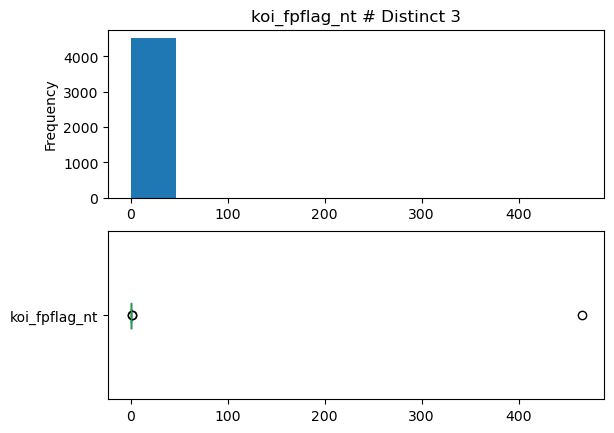

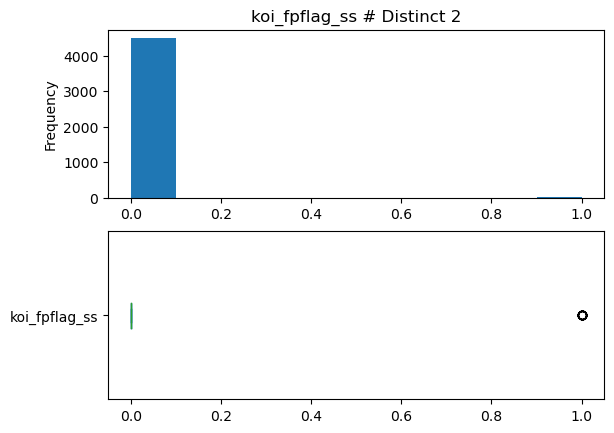

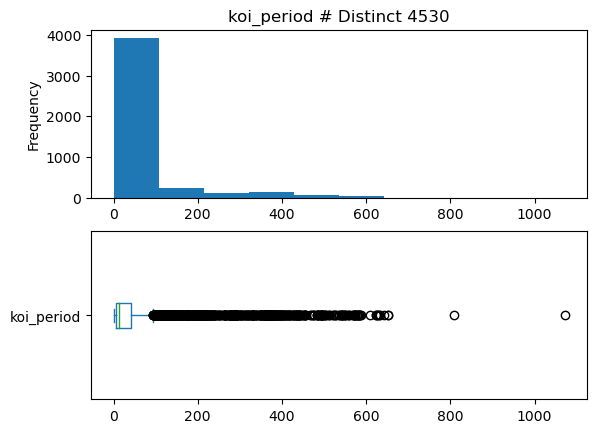

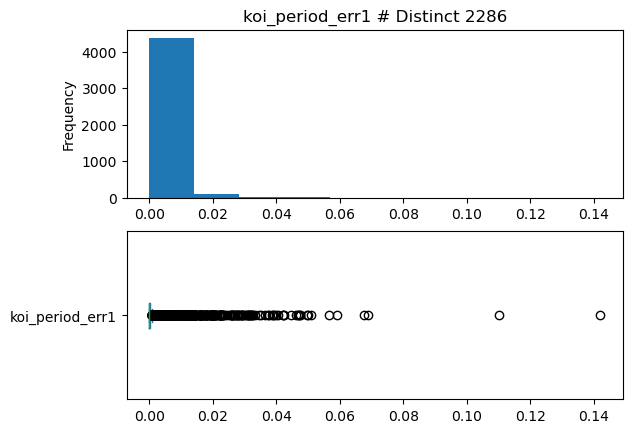

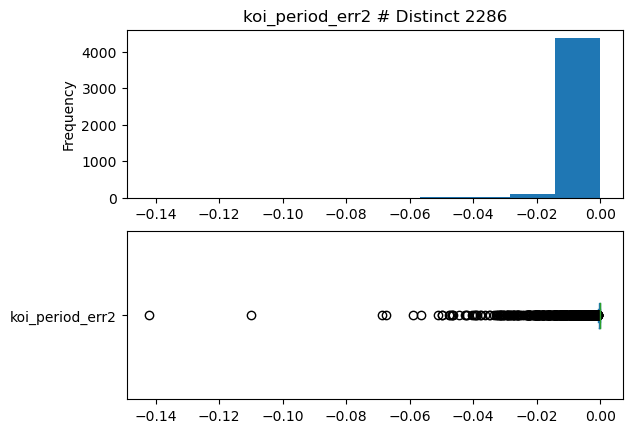

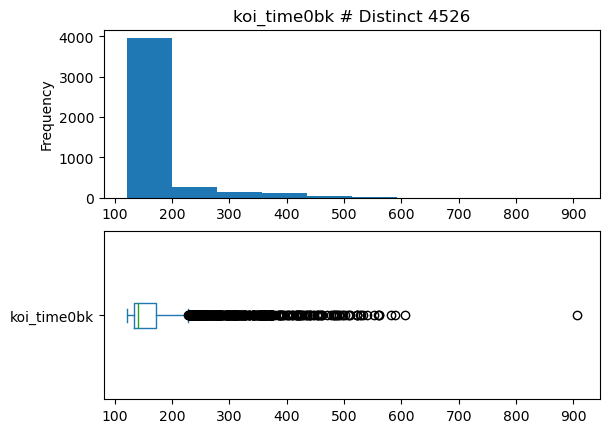

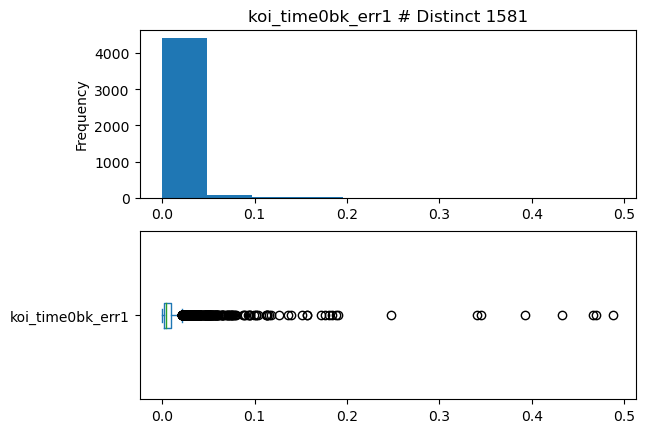

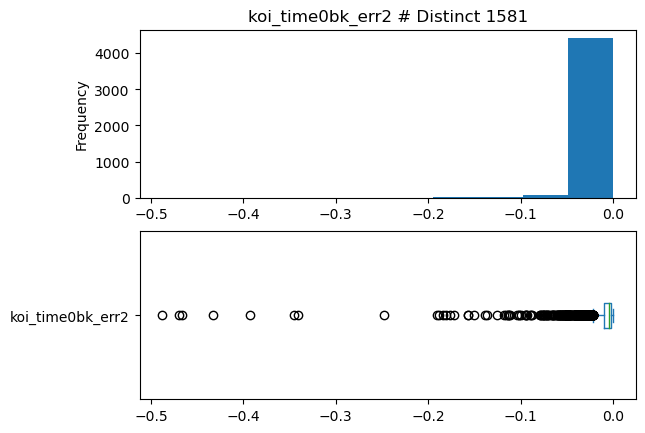

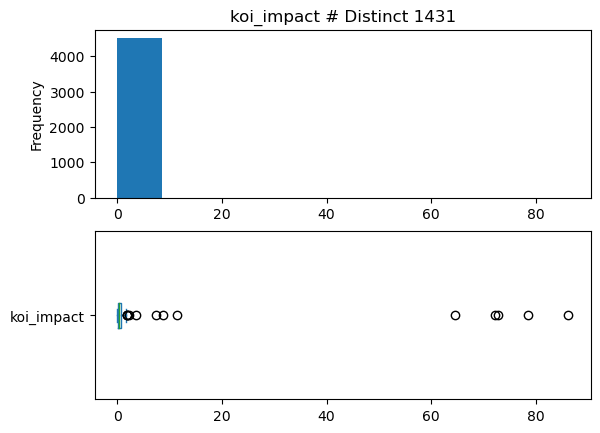

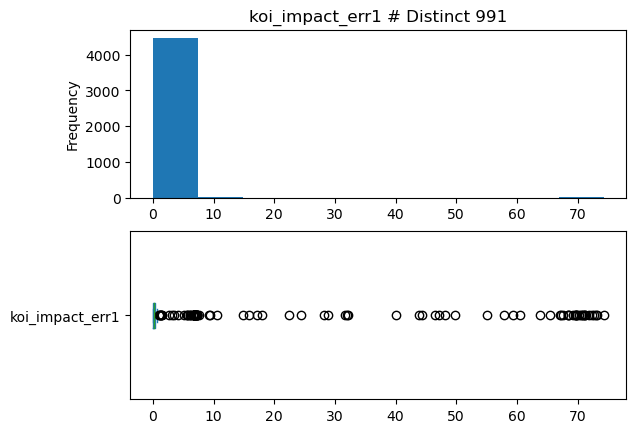

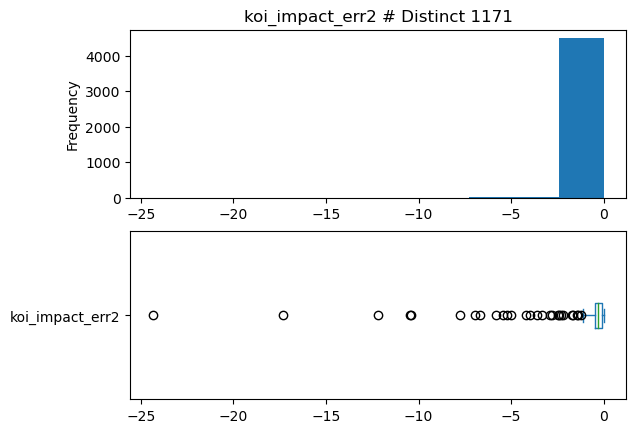

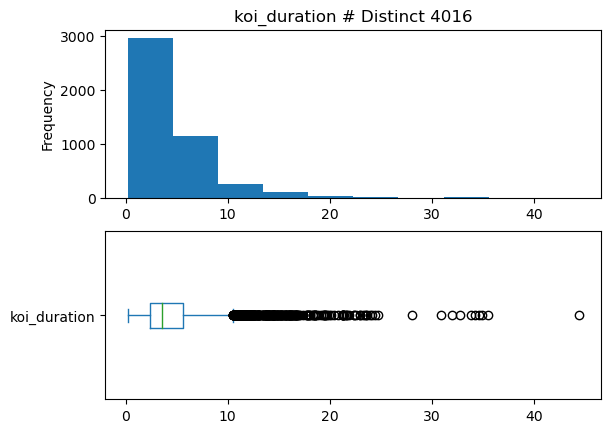

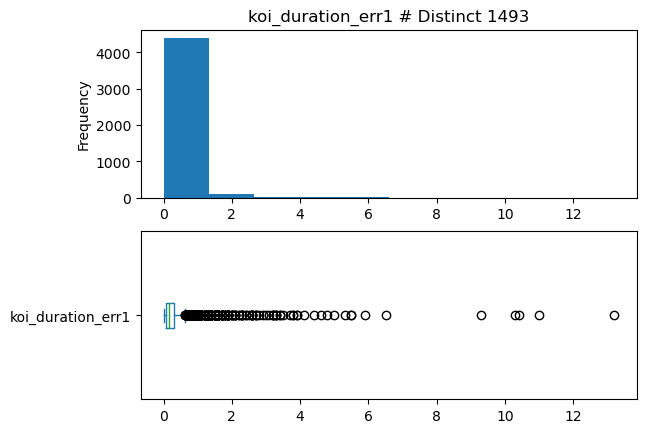

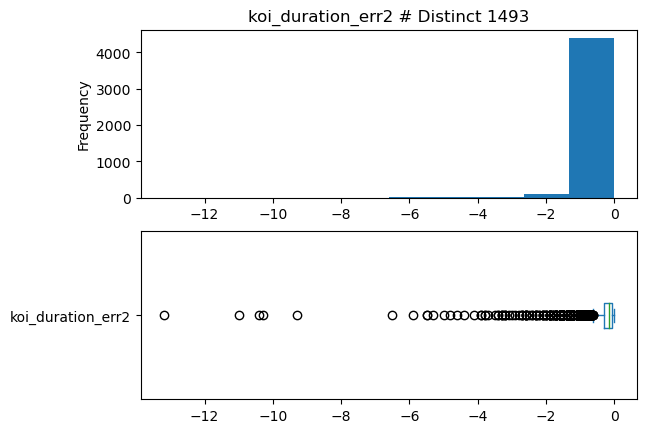

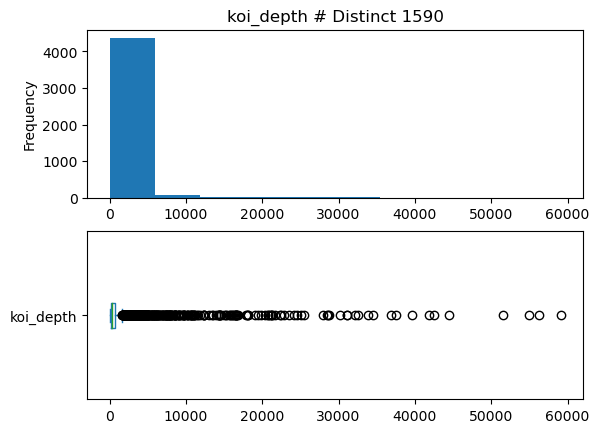

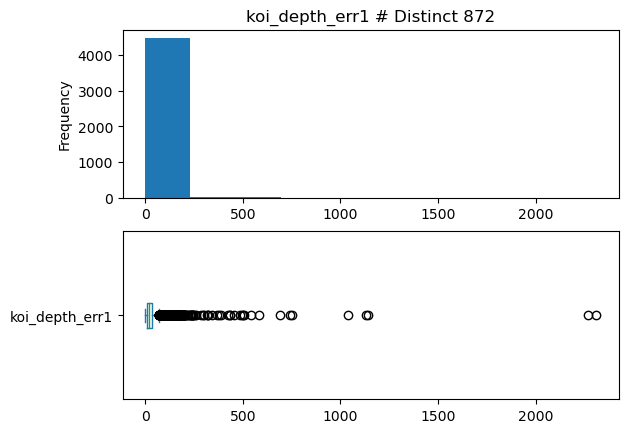

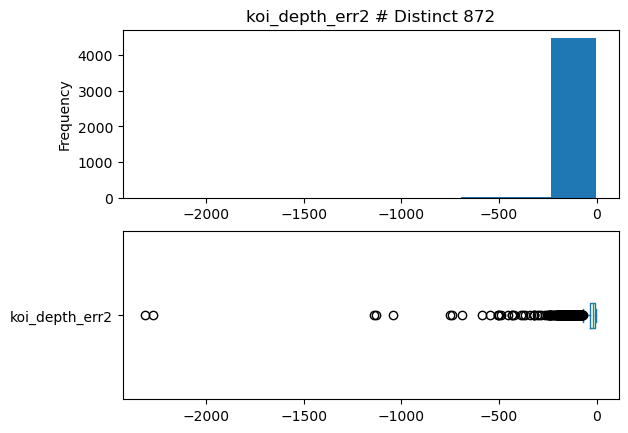

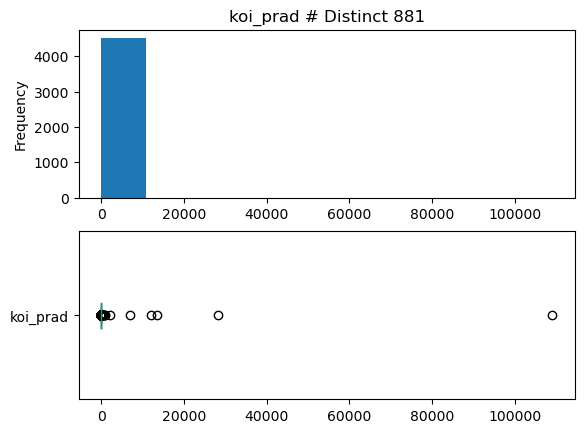

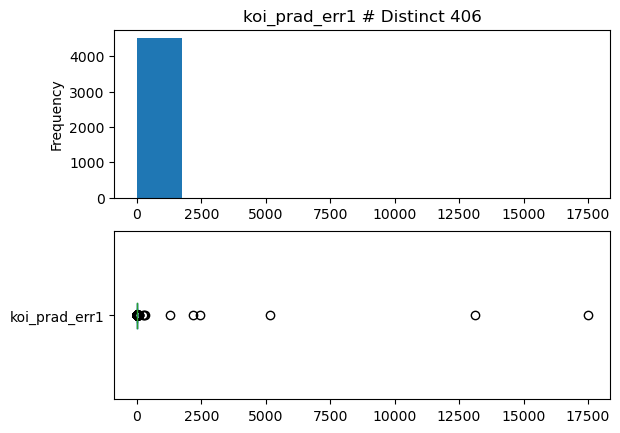

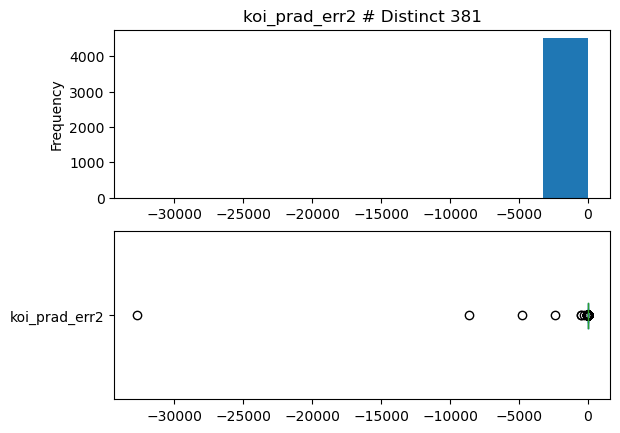

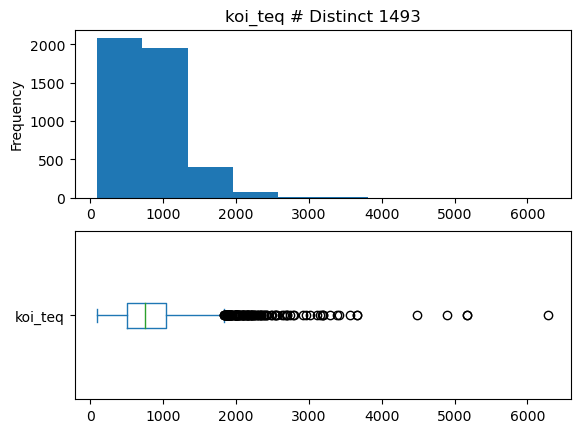

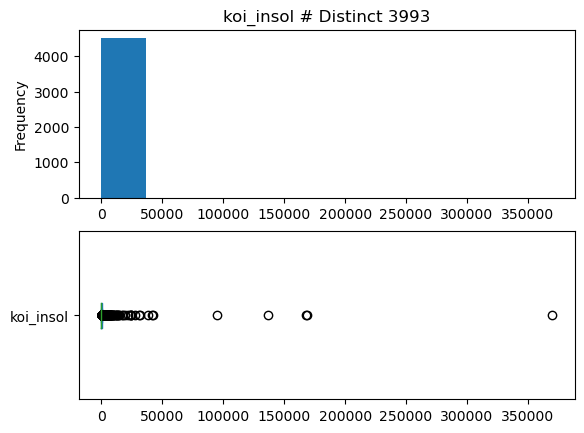

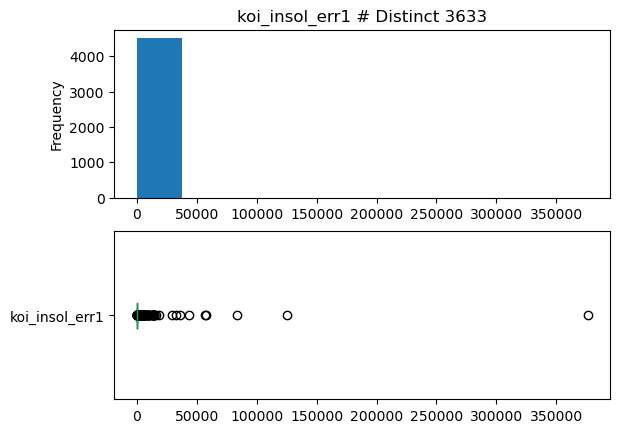

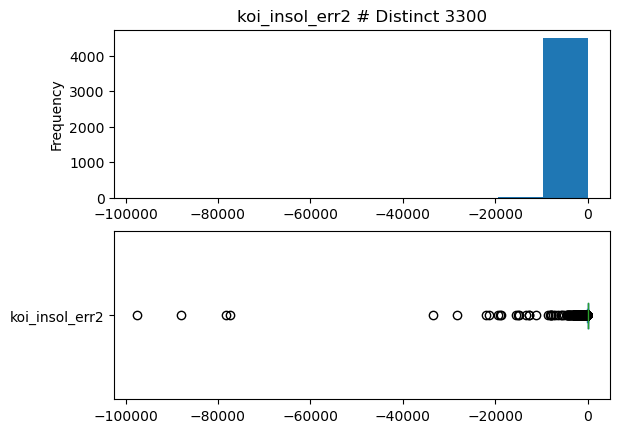

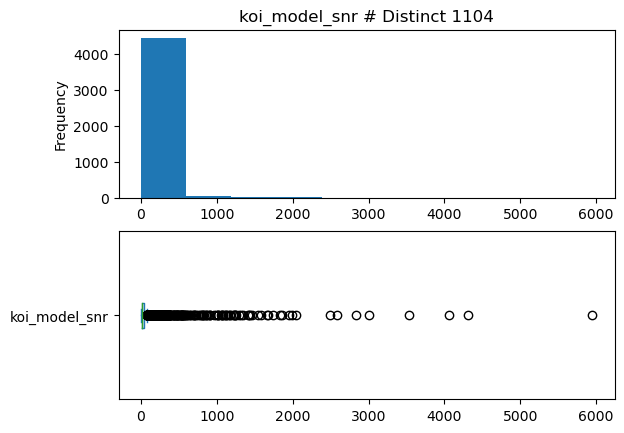

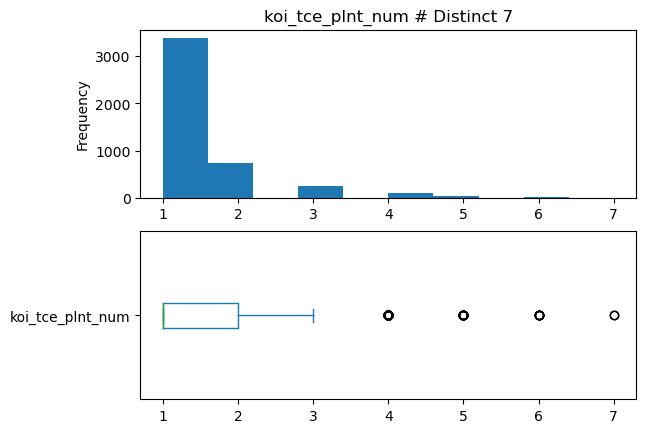

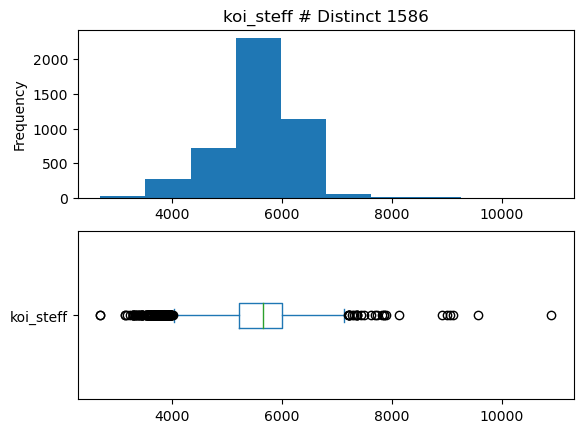

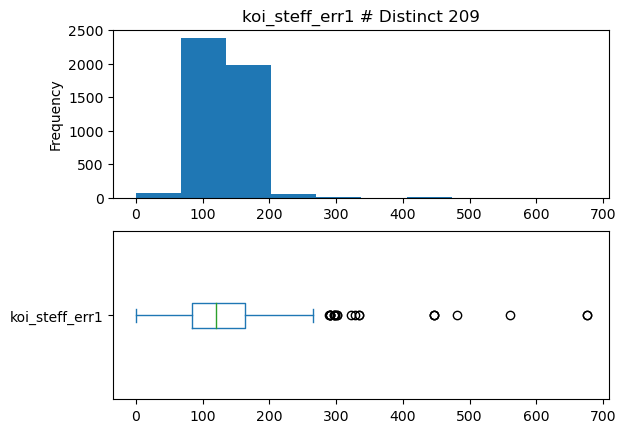

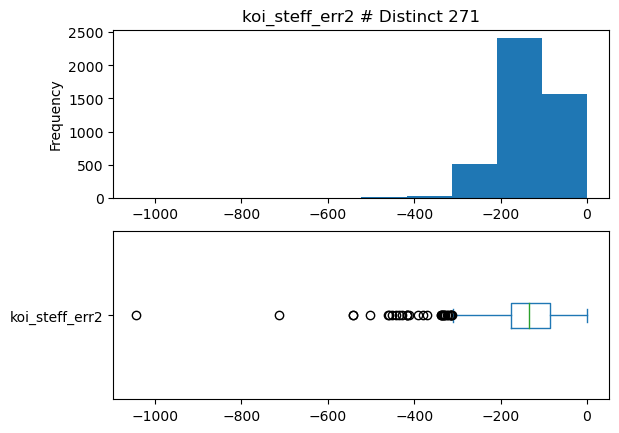

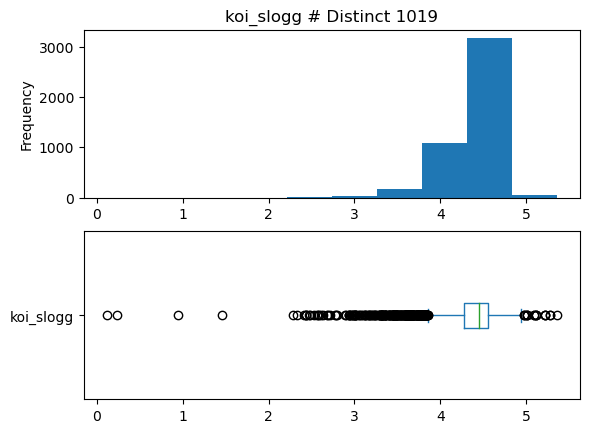

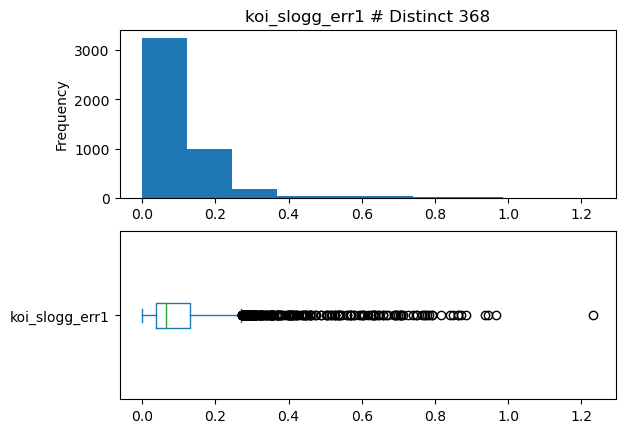

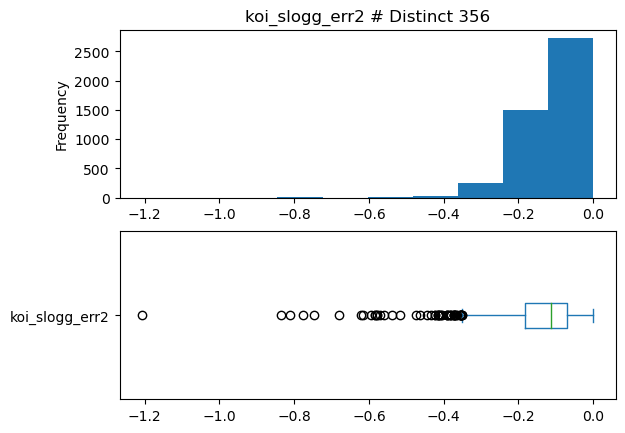

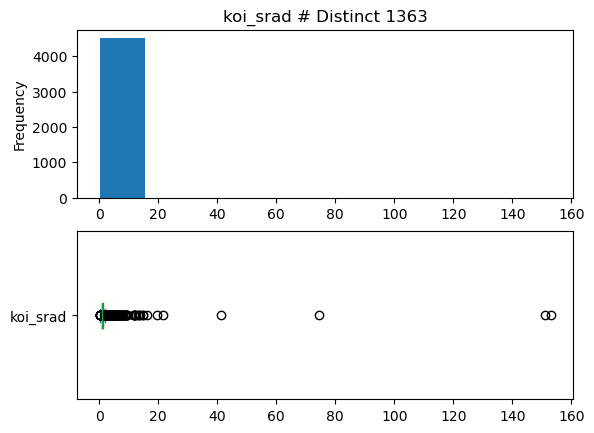

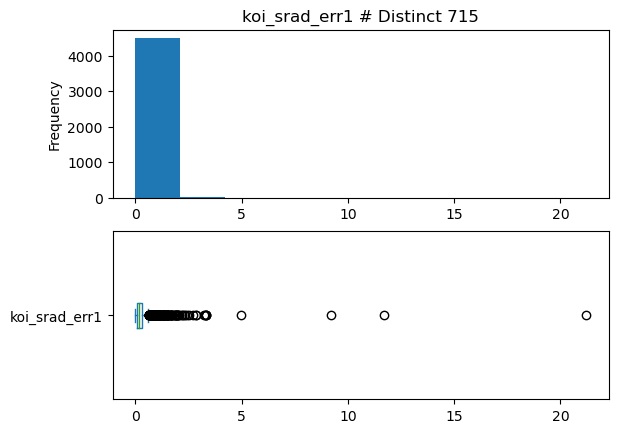

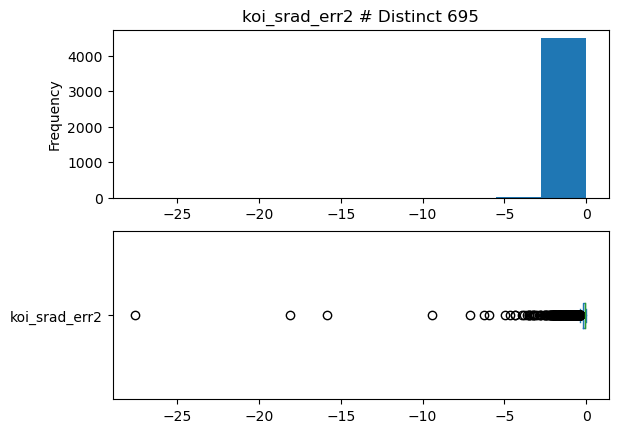

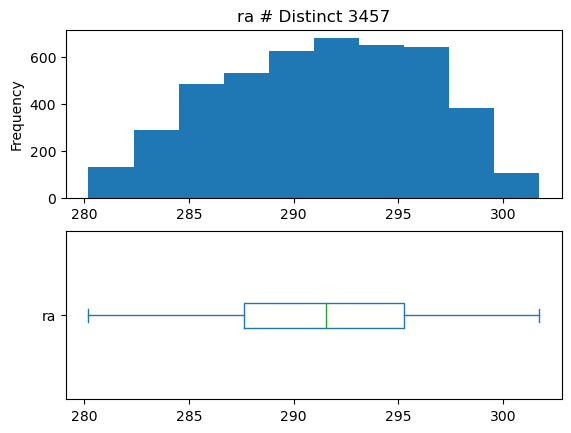

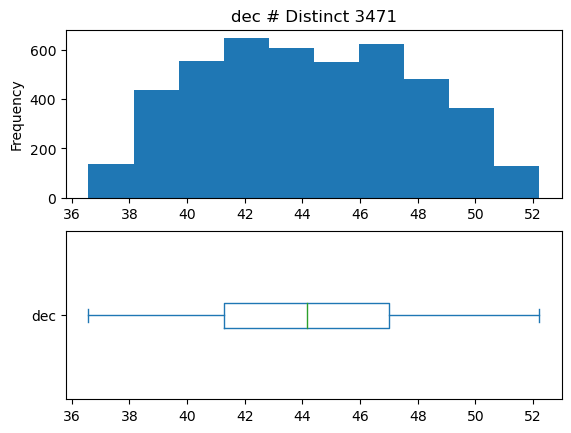

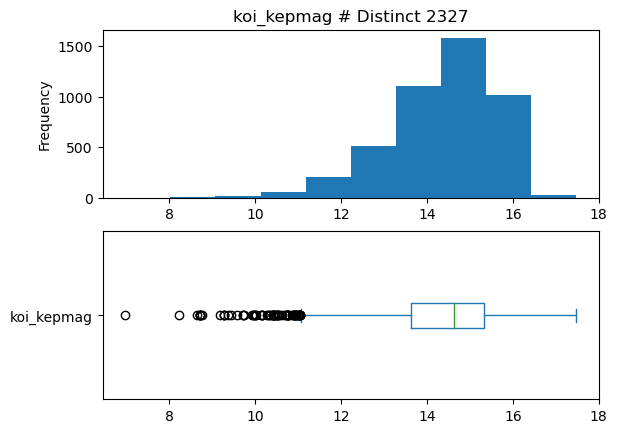

In [136]:
# Plots! OH yeah!

for col in df:
    var = df[col]
    if var.dtype.kind != 'O':
        
        fig,axs = plt.subplots(2,1)
        _ = var.plot.hist(ax=axs[0])
        _ = var.plot.box(ax=axs[1],vert=False)
        
        axs[0].set_title(f"{col} # Distinct {len(var.drop_duplicates())}")
        plt.show()
        

In [ ]:
def preprocessing(df):
    """
    Perform preprocessing steps:
    1. Drop all missing variables
    """
    return 0
